# Draw Interpolated PSF


Interpolate the PSF within the simulated ray grid

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : June 3rd 2020


In [329]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

In [330]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [331]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [332]:
from scipy import interpolate

In [333]:
from sklearn.neighbors import NearestNeighbors

In [334]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [335]:
from datetime import datetime,date

In [336]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

## Constants for conversions

In [337]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [338]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [339]:
deg_to_rad=np.pi/180.

In [340]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [341]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [342]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=16.37 arcsec per mm 


In [343]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 61.09 microns


In [344]:
1/pltscale*mm_to_micr/2.36*3

77.65228784593788

#### filter

In [345]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [346]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [347]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [348]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [349]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [350]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [351]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [352]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [353]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [354]:
order="OP1"
order_str="+1"

# Read input files

In [355]:
FLAG_R350=True # show RON350 instead of R200

In [356]:
#rayfile_hoe=Beam4_Rayfile+"_RAY_HOE_OUT.xlsx"
#rayfile_R400=Beam4_Rayfile+"_RAY_RON400_OUT.xlsx"
#rayfile_R200=Beam4_Rayfile+"_RAY_RON200_OUT.xlsx"
#rayfile_R350=Beam4_Rayfile+"_RAY_RON350_OUT.xlsx"

In [357]:
rayfile_R200="R200_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R350="R350_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R400="R400_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_hoe="HOE_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R300="R300_Beam4_Rayfile_484_allwl_m00_m00_2020_05_31_B4OUT_RAY.xlsx"

In [358]:
input_hoe = pd.ExcelFile(rayfile_hoe)
df_hoe = input_hoe.parse(index_row=0,header=1)
df_hoe=df_hoe.iloc[0:NBTOT]

In [359]:
# rename columns otherwise they are not recognize and swap X,Y
#df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]
#df_hoe.columns = ["Y0","X0","Z0","V0","U0","W0","wave","Y1","X1","Z1","Y2","X2","Z2","Y3","X3","Z3","Yfinal","Xfinal","Zfinal","Notes"]

In [360]:
df_hoe

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.27790,-0.01283,79.99998,0,0,8.27790,-0.01283,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.28523,-0.01285,79.99998,0,0,8.28523,-0.01285,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.29260,-0.01287,79.99998,0,0,8.29260,-0.01287,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842679,-2.10670,...,8.30001,-0.01289,79.99998,0,0,8.30001,-0.01289,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.30745,-0.01291,79.99998,0,0,8.30745,-0.01291,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.97558,-0.05372,79.99998,0,0,21.97558,-0.05372,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842679,2.10670,...,21.94330,-0.05361,79.99998,0,0,21.94330,-0.05361,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.91098,-0.05350,79.99998,0,0,21.91098,-0.05350,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.87866,-0.05338,79.99998,0,0,21.87866,-0.05338,80,OK,3


In [361]:
input_R400 = pd.ExcelFile(rayfile_R400)
df_R400 = input_R400.parse(index_row=0,header=1)
df_R400=df_R400.iloc[0:NBTOT]

In [362]:
# rename columns otherwise they are not recognize
#df_R400.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [363]:
df_R400

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,9.50870,0.03953,80,0,0,9.50870,0.03953,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,9.48531,0.03701,80,0,0,9.48531,0.03701,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,9.46349,0.03451,80,0,0,9.46349,0.03451,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,9.44321,0.03201,80,0,0,9.44321,0.03201,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,9.42447,0.02953,80,0,0,9.42447,0.02953,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,25.21121,-0.18127,80,0,0,25.21121,-0.18127,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,25.09532,-0.17373,80,0,0,25.09532,-0.17373,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,24.98470,-0.16628,80,0,0,24.98470,-0.16628,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,24.87929,-0.15892,80,0,0,24.87929,-0.15892,80,OK,3


In [364]:
input_R300 = pd.ExcelFile(rayfile_R300)
df_R300 = input_R300.parse(index_row=0,header=1)
df_R300=df_R300.iloc[0:NBTOT]

In [365]:
df_R300

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,7.07474,0.02426,80,0,0,7.07474,0.02426,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,7.06058,0.02241,80,0,0,7.06058,0.02241,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,7.04756,0.02057,80,0,0,7.04756,0.02057,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,7.03565,0.01874,80,0,0,7.03565,0.01874,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,7.02487,0.01691,80,0,0,7.02487,0.01691,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,18.19158,-0.09504,80,0,0,18.19158,-0.09504,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,18.13355,-0.08999,80,0,0,18.13355,-0.08999,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,18.07880,-0.08500,80,0,0,18.07880,-0.08500,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,18.02729,-0.08003,80,0,0,18.02729,-0.08003,80,OK,3


In [366]:
input_R200 = pd.ExcelFile(rayfile_R200)
df_R200 = input_R200.parse(index_row=0,header=1)
df_R200=df_R200.iloc[0:NBTOT]

In [367]:
# rename columns otherwise they are not recognize
#df_R200.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [368]:
df_R200

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,4.68705,0.01269,80,0,0,4.68705,0.01269,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,4.67976,0.01147,80,0,0,4.67976,0.01147,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,4.67321,0.01027,80,0,0,4.67321,0.01027,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,4.66738,0.00906,80,0,0,4.66738,0.00906,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,4.66228,0.00786,80,0,0,4.66228,0.00786,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,11.82185,-0.03962,80,0,0,11.82185,-0.03962,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,11.79859,-0.03650,80,0,0,11.79859,-0.03650,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,11.77726,-0.03340,80,0,0,11.77726,-0.03340,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,11.75785,-0.03031,80,0,0,11.75785,-0.03031,80,OK,3


In [369]:
input_R350 = pd.ExcelFile(rayfile_R350)
df_R350 = input_R350.parse(index_row=0,header=1)
df_R350=df_R350.iloc[0:NBTOT]

In [370]:
df_R350

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.28509,0.03142,80,0,0,8.28509,0.03142,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.26662,0.02923,80,0,0,8.26662,0.02923,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.24951,0.02707,80,0,0,8.24951,0.02707,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,8.23371,0.02491,80,0,0,8.23371,0.02491,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.21925,0.02276,80,0,0,8.21925,0.02276,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.59873,-0.13376,80,0,0,21.59873,-0.13376,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,21.51529,-0.12756,80,0,0,21.51529,-0.12756,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.43600,-0.12143,80,0,0,21.43600,-0.12143,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.36083,-0.11535,80,0,0,21.36083,-0.11535,80,OK,3


# Choose disperser

In [371]:
FLAG_R400 = False
FLAG_R300 = True
FLAG_R350 = False
FLAG_R200 = False
FLAG_HOE = False

In [372]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [373]:
if FLAG_R400:
    df=df_R400
    outputdata_excel="R400_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R400_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R400_PSF_" +   Beam4_Rayfile+".pdf"  
    figname3="R400_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="Ronchi 400 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 400 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
elif FLAG_R300:
    df=df_R300
    outputdata_excel="R300_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R300_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R300_PSF_" +   Beam4_Rayfile+".pdf"  
    figname3="R300_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="Ronchi 300 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 300 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    
elif FLAG_R350:
    df=df_R350
    outputdata_excel="R350_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R350_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R350_PSF_" +   Beam4_Rayfile+".pdf"
    figname3="R350_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="Ronchi 350 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 350 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
elif FLAG_R200:
    df=df_R200
    outputdata_excel="R200_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R200_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R200_PSF_" +   Beam4_Rayfile+".pdf"
    figname3="R200_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="Ronchi 200 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 200 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
else:
    df=df_hoe
    outputdata_excel="HOE_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="HOE_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="HOE_PSF_" +   Beam4_Rayfile+".pdf" 
    figname3="HOE_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="HOE : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="HOE : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)

# Show beam

In [374]:
X0C=df["X0"].mean()
Y0C=df["Y0"].mean()

In [375]:
RXMAX=np.max(np.abs(df["X0"].values-X0C))
RYMAX=np.max(np.abs(df["Y0"].values-Y0C))          

In [376]:
RMAX=np.max(np.array([RXMAX,RYMAX]))

In [377]:
RMAX

2.8565355

In [378]:
def Select_Beam(row):
    return (row["X0"]-X0C)**2+(row["Y0"]-Y0C)**2 <= RMAX**2

Text(0.5, 0.98, 'Unfiltered square beam')

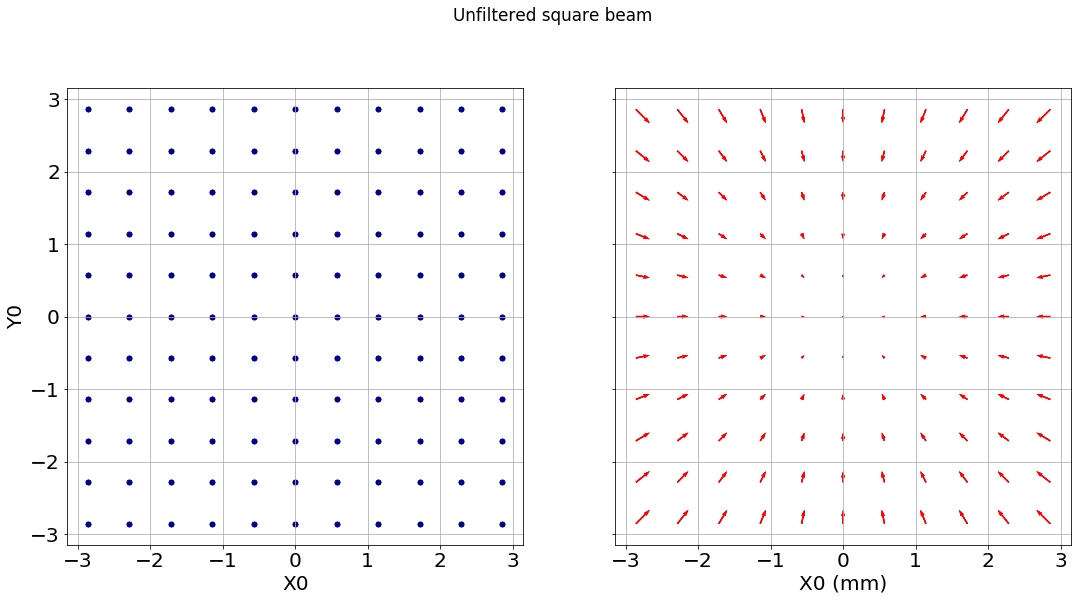

In [379]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df["X0"], df["Y0"], df["U0"], df["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("Unfiltered square beam")

In [380]:
#df_filter=df.copy()

In [381]:
#df_filter["sel_flag"]= df_filter.apply(Select_Beam, axis=1)

In [382]:
#df_filter

In [383]:
# Do the filtering of the selected rays
#df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]

In [384]:
#f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
#df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
#ax1.set_aspect("equal")
#ax1.grid()

#q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
#ax2.set_aspect("equal")
#ax2.set_xlabel("X0 (mm)")
#ax2.grid()

#plt.suptitle("Filtered circular beam")

## reafect df_filter to df

In [385]:
#df_filter=df_filter.reset_index()   # reset index
#df=df_filter.copy()

In [386]:
#df.reindex()

In [387]:
NBEAMS=len(df)

## Select one wavelength

In [388]:
#WL_IR=0.001

WL_IR=0.0004

In [389]:
df_IR=df.loc[df.wave==WL_IR]

In [390]:
NBEAMS=len(df_IR)

In [391]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBEAMS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBEAMS), alpha=1)

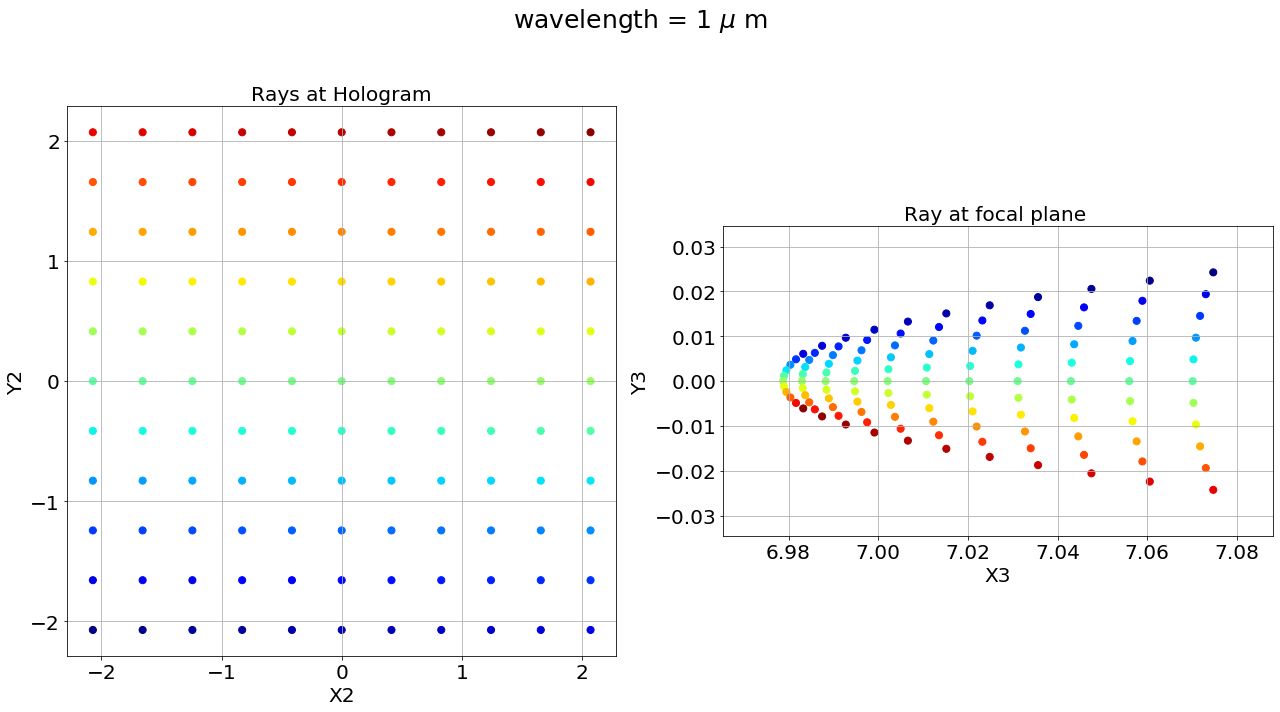

In [392]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9))
df_IR.plot.scatter(x="X2", y="Y2",c=all_colors,marker="o",ax=ax1,s=50)
ax1.set_aspect("equal")
ax1.grid()
ax1.set_title("Rays at Hologram")


df_IR.plot.scatter(x="X3", y="Y3",c=all_colors,marker="o",ax=ax2,s=50)
ax2.set_aspect("equal")
ax2.grid()
ax2.set_title("Ray at focal plane ")

plt.suptitle("wavelength = 1 $\mu$ m",Y=1.1,fontsize=25)
plt.tight_layout()

# 1D PSF

Text(0.5, 0, 'Y (mm)')

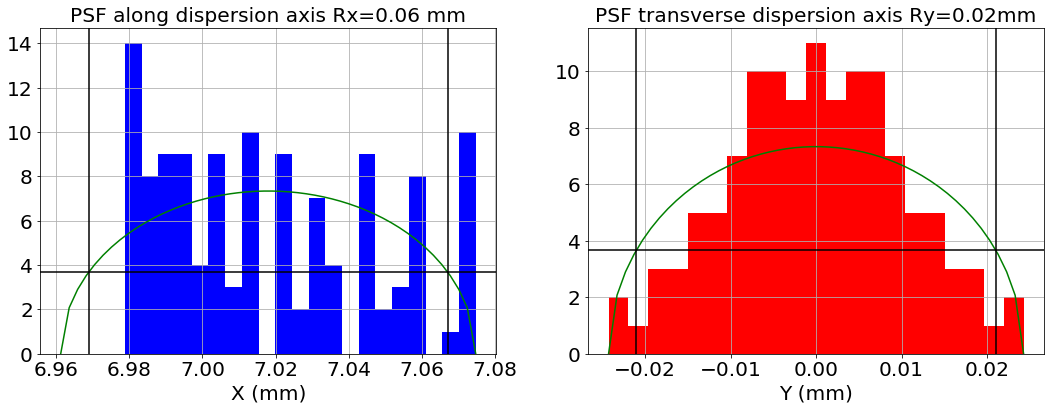

In [393]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,6))
Xpos=df_IR["X3"].values
Ypos=df_IR["Y3"].values
NBINS=21
X3C=Xpos.mean()
Y3C=Ypos.mean()

RX=Xpos.max()-X3C
RY=Ypos.max()-Y3C

h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)

counts1, bins1 = h1
counts2, bins2 = h2

NPOINTS=50
all_x=np.linspace(-RX,RX,NPOINTS)
all_y=np.linspace(-RY,RY,NPOINTS)
DX=2/NBINS*NBEAMS*(2*RX)
DY=2/NBINS*NBEAMS*(2*RY)

Yx=1/np.pi/RX*DX*np.sqrt(1-all_x**2/RX**2)
Yy=1/np.pi/RY*DY*np.sqrt(1-all_y**2/RY**2)
YxMax=1/np.pi/RX*DX
YyMax=1/np.pi/RY*DY

#ax1.hist(Xpos,bins=NBINS,facecolor="blue",density=True)
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="blue",density=False)
ax1.plot(all_x+Xpos.mean(),Yx,color='green')
ax1.grid()
ax1.set_title("PSF along dispersion axis Rx={:2.2f} mm".format(RX))
ax1.axhline(y=YxMax/2,color="k")
ax1.axvline(x=-np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.axvline(x=np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.set_xlabel("X (mm)")

#ax2.hist(Ypos,bins=NBINS,facecolor="red",density=True)
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",density=False)
ax2.plot(all_y+Ypos.mean(),Yy,color="green")
ax2.axhline(y=YyMax/2.,color="k")
ax2.axvline(x=-np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.axvline(x=np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.grid()
ax2.set_title("PSF transverse dispersion axis Ry={:2.2f}mm".format(RY))
ax2.set_xlabel("Y (mm)")

# Uniform sampling of the surface

In [394]:
NSIMRAYS=200000

In [395]:
SIMRAYS_COORDINATES=(np.random.random((NSIMRAYS,2))-0.5)*2*RMAX

In [396]:
simrays_sel_idx=np.where(SIMRAYS_COORDINATES[:,0]**2+SIMRAYS_COORDINATES[:,1]**2<(RMAX)**2)[0]

In [397]:
SIMRAYSSEL_COORDINATES = SIMRAYS_COORDINATES[simrays_sel_idx]

In [398]:
SIMRAYSSEL_COORDINATES = SIMRAYSSEL_COORDINATES # -np.array([X0C,Y0C])   recenter the beam at hologram place

In [399]:
NBSIMRAYSSEL=len(SIMRAYSSEL_COORDINATES)

Text(0.5, 1.0, ' Random beam')

<Figure size 864x720 with 0 Axes>

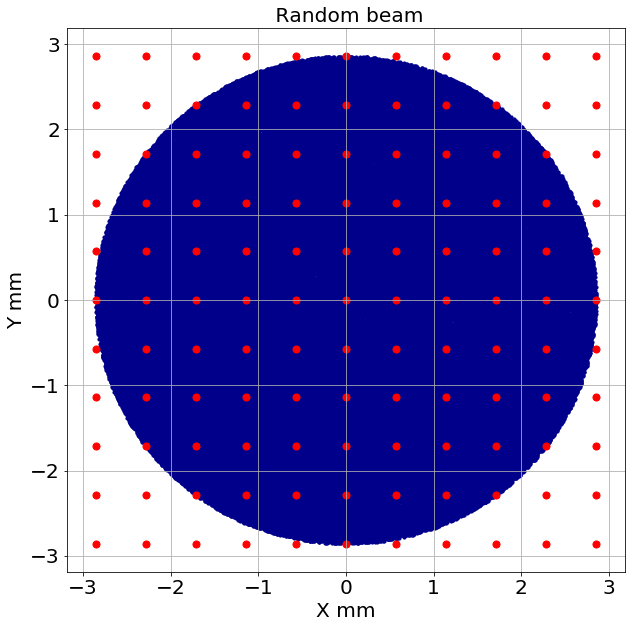

In [400]:
plt.figure(figsize=(12,10))
f, ax = plt.subplots(figsize=(10,10))
ax.scatter(SIMRAYSSEL_COORDINATES[:,0],SIMRAYSSEL_COORDINATES[:,1],marker="o" ,color="DarkBlue",s=10)
ax.scatter(df_IR["X0"].values, df_IR["Y0"],marker="o" ,color="red",s=50)
ax.grid()
ax.set_aspect("auto")
ax.set_xlabel("X mm")
ax.set_ylabel("Y mm")
ax.set_title(" Random beam")

# K neareast neightbourg

## Defines the reference sample of rays simulated bu B4

In [401]:
X=df_IR["X0"].values
Y=df_IR["Y0"].values
Z1=df_IR["X3"].values
Z2=df_IR["Y3"].values

refXY = np.dstack((X,Y))[0]

## Fit KNN

In [402]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(refXY)

## Find the neighbours of simulated resampled

In [403]:
distances, indices = nbrs.kneighbors(SIMRAYSSEL_COORDINATES) 

# 2D bilinear Interpolation
    

In [404]:
Xccd=np.zeros(NBSIMRAYSSEL)
Yccd=np.zeros(NBSIMRAYSSEL)

for idx in np.arange(NBSIMRAYSSEL):
    dd=distances[idx]
    indrays=indices[idx]
    
    
    # reference rays original coordinates
    theX=df_IR.iloc[indrays]["X0"].values
    theY=df_IR.iloc[indrays]["Y0"].values
    
    # reference rays final coordinates on CCD
    ZX=df_IR.iloc[indrays]["X3"].values
    ZY=df_IR.iloc[indrays]["Y3"].values
    
    fX = interpolate.interp2d(theX, theY, ZX, kind='linear')
    fY = interpolate.interp2d(theX, theY, ZY, kind='linear')
    
    Xccd[idx]=fX(SIMRAYSSEL_COORDINATES[idx,0],SIMRAYSSEL_COORDINATES[idx,1])
    Yccd[idx]=fY(SIMRAYSSEL_COORDINATES[idx,0],SIMRAYSSEL_COORDINATES[idx,1])
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=4 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Text(0.5, 1.0, ' Random beam on CCD')

<Figure size 864x720 with 0 Axes>

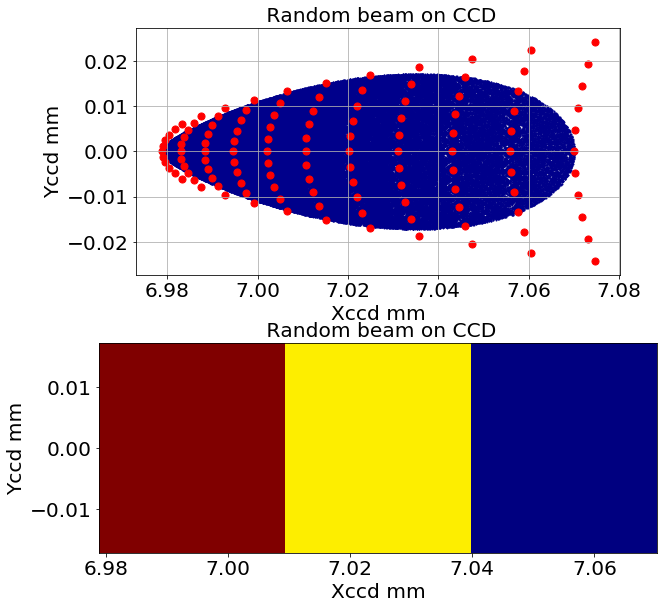

In [405]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm) 

ax1.scatter(Xccd,Yccd,marker="o" ,color="DarkBlue",s=1)
ax1.scatter(df_IR["X3"].values, df_IR["Y3"],marker="o" ,color="red",s=50)
ax1.grid()
ax1.set_aspect("equal")
ax1.set_xlabel("Xccd mm")
ax1.set_ylabel("Yccd mm")
ax1.set_title(" Random beam on CCD")

ax2.hist2d(Xccd,Yccd,bins=(NBINX,NBINY),cmap=cm.get_cmap('jet', 512))
ax2.set_aspect("equal")
ax2.set_xlabel("Xccd mm")
ax2.set_ylabel("Yccd mm")
ax2.set_title(" Random beam on CCD")

## Histogram and Fit

In [406]:
def ComputeFWHM(values,nbins,thetitle="fwhm",thexlabel="X ($\mu m$)",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

### histogram in CCD pixels

In [407]:
NBINSX=int((Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm))
NBINSY=int((Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)) 

# compute the histogram
h1=np.histogram(Xccd,bins=NBINSX)
h2=np.histogram(Yccd,bins=NBINSY)

counts1, bins1 = h1
counts2, bins2 = h2


# compute bin width
# compute bin width
binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
binwidth1=np.mean(binwidths1)

binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit

theX1=(bins1+binwidth1/2)[:-1]
theY1=counts1

theX2=(bins2+binwidth2/2)[:-1]
theY2=counts2

TypeError: Improper input: N=3 must not exceed M=1

<Figure size 864x720 with 0 Axes>

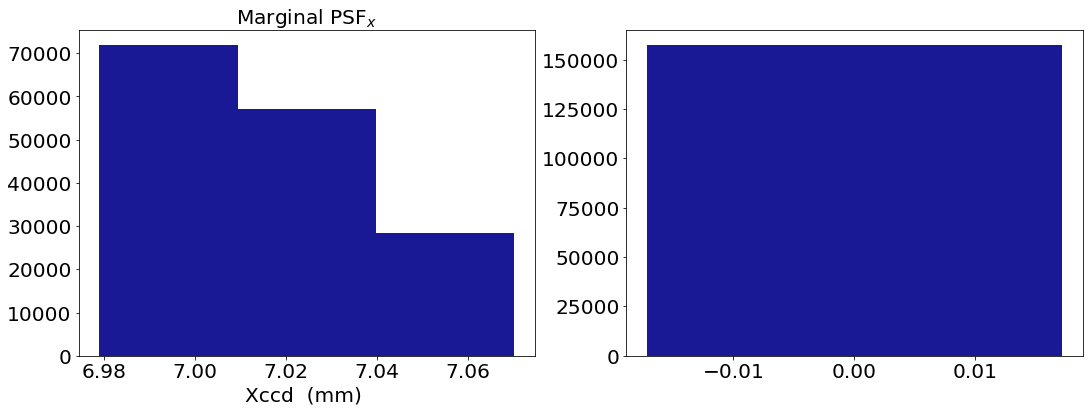

In [408]:
plt.figure(figsize=(12,10))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))


# in X
#ax1.hist(Xccd,bins=NBINSX,facecolor="blue")
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="DarkBlue",density=False,alpha=0.9)
ax1.set_xlabel("Xccd  (mm) ")
ax1.set_title("Marginal PSF$_x$")

# in Y
#ax2.hist(Yccd,bins=NBINSY,facecolor="blue")
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="DarkBlue",density=False,alpha=0.9)

# gaussian fit
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, theX2,theY2,weights=1)
print(best_fit_gauss)

ax2.set_xlabel("Yccd (mm)")
ax2.set_title("Marginal PSF$_y$")

### Compute FWHM 

0.06396218552325905

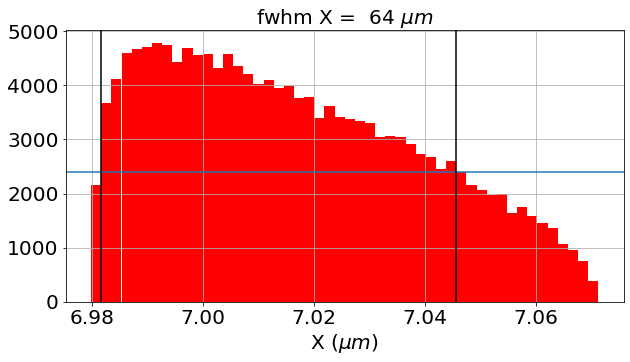

In [409]:
ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X ($\mu m$)",flagplot=True)

0.01991271389522184

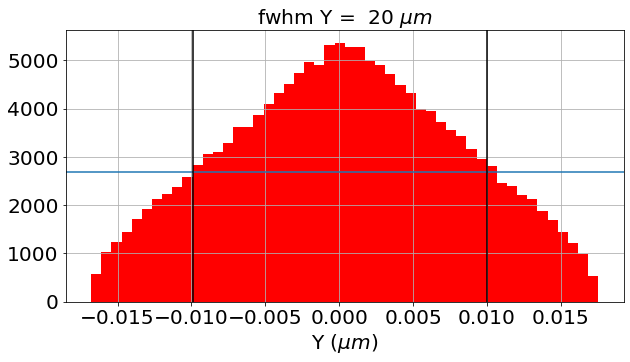

In [410]:
ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y ($\mu m$)",flagplot=True)

# Fit

In [1]:
@custom_model
def exponential(x, a=10., b=1., c=0.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(-np.abs(b*(x-c)))

NameError: name 'custom_model' is not defined